# Transfomers Implementation

A transformer is a deep learning model that adopts the mechanism of attention, differentially weighing the significance of each part of the input data. It is used primarily in the field of natural language processing (NLP) and in computer vision (CV).

Like recurrent neural networks (RNNs), transformers are designed to handle sequential input data, such as natural language, for tasks such as translation and text summarization. However, unlike RNNs, transformers do not necessarily process the data in order. Rather, the attention mechanism provides context for any position in the input sequence. For example, if the input data is a natural language sentence, the transformer does not need to process the beginning of the sentence before the end. Rather, it identifies the context that confers meaning to each word in the sentence. This feature allows for more parallelization than RNNs and therefore reduces training times.

https://arxiv.org/pdf/1706.03762.pdf

<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>This tutorial: An encoder/decoder connected by attention.</th>
<tr>
</table>
.

## Setup

In [1]:
!pip install torchtext==0.16.0 torch==2.1.0
!pip install einops


In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [3]:
# ShapeChecker class to validate tensor shapes
class ShapeChecker:
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}
    
    def __call__(self, tensor, names, broadcast=False):
        if not torch.is_grad_enabled():
            return
    
        parsed = einops.parse_shape(tensor, names)
    
        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)
    
            if broadcast and new_dim == 1:
                continue
    
            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue
    
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")


## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [4]:
import pathlib
import requests
import zipfile

# Download the file
url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
response = requests.get(url)
with open('spa-eng.zip', 'wb') as f:
    f.write(response.content)

# Extract the zip file
with zipfile.ZipFile('spa-eng.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

path_to_file = pathlib.Path('spa-eng/spa.txt')

In [5]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    
    context = [context for target, context in pairs]
    target = [target for target, context in pairs]
    
    return target, context

In [6]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [7]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a dataset

BUFFER_SIZE is typically used in the context of shuffling your dataset. When you shuffle a dataset, it randomly reorders the elements, which is beneficial for training machine learning models to avoid any order-related biases.

BATCH_SIZE specifies the number of elements (samples) that will be combined into a single batch in your dataset. Batching is used to improve training efficiency by processing multiple data points at once, which is particularly important when working with large datasets.

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [8]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# Split the data into training and validation sets (80-20 split)
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_context = [context_raw[i] for i in range(len(context_raw)) if is_train[i]]
train_target = [target_raw[i] for i in range(len(target_raw)) if is_train[i]]

val_context = [context_raw[i] for i in range(len(context_raw)) if not is_train[i]]
val_target = [target_raw[i] for i in range(len(target_raw)) if not is_train[i]]

# Define a custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, contexts, targets):
        self.contexts = contexts
        self.targets = targets
    
    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        return self.contexts[idx], self.targets[idx]

# Create Dataset instances
train_dataset = TranslationDataset(train_context, train_target)
val_dataset = TranslationDataset(val_context, val_target)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [9]:
for example_context_strings, example_target_strings in train_loader:
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

('Tom no cree que se vaya a meter en problemas.', 'Quiero un reporte completo antes de las 2:30.', 'Mi mujer lleva un vestido azul.', '¿Por qué tienes tantos gatos?', 'Mi abuelo sale a caminar todos los días.')

("Tom doesn't think he'll get in trouble.", 'I want a full report before 2:30.', 'My wife is wearing a blue dress.', 'Why do you have so many cats?', 'My grandfather goes for a walk every day.')


### Text preprocessing

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

In [10]:
example_text = '¿Todavía está en casa?'

# Normalize UTF8 (Equivalent functionality can be achieved using Unicode normalization)
import unicodedata

def normalize_utf8(text):
    return unicodedata.normalize('NFKD', text)

print(example_text.encode('utf-8'))
print(normalize_utf8(example_text).encode('utf-8'))

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [11]:
def torch_lower_and_split_punct(text):
    # Split accented characters.
    text = unicodedata.normalize('NFKD', text)
    text = text.lower()
    # Keep space, a to z, and select punctuation.
    import re
    text = re.sub(r'[^ a-z.?!,¿]', '', text)
    # Add spaces around punctuation.
    text = re.sub(r'([.?!,¿])', r' \1 ', text)
    # Strip whitespace.
    text = text.strip()
    
    text = '[START] ' + text + ' [END]'
    return text

In [12]:
print(example_text)
processed_text = torch_lower_and_split_punct(example_text)
print(processed_text)

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

In [13]:
max_vocab_size = 5000

# Initialize tokenizers
tokenizer = get_tokenizer('basic_english')

# Build vocabulary for context
def build_vocab(data):
    return build_vocab_from_iterator(map(tokenizer, data), specials=['[UNK]', '[START]', '[END]'], max_tokens=max_vocab_size)

context_vocab = build_vocab(train_context)
context_vocab.set_default_index(context_vocab['[UNK]'])

# Similarly, build vocabulary for target
target_vocab = build_vocab(train_target)
target_vocab.set_default_index(target_vocab['[UNK]'])

In [14]:
# Vocabulary has already been built in Cell 13
# Display first 10 tokens in context vocabulary
print(context_vocab.get_itos()[:10])

['[UNK]', '[START]', '[END]', '.', 'de', 'que', 'a', 'no', 'tom', 'la']


That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [15]:
# Display first 10 tokens in target vocabulary
print(target_vocab.get_itos()[:10])

['[UNK]', '[START]', '[END]', '.', "'", 'i', 'the', 'to', 'you', 'tom']


Now these layers can convert a batch of strings into a batch of token IDs:

In [16]:
example_tokens = [torch.tensor(context_vocab(tokenizer(context))) for context in example_context_strings[:3]]
print(example_tokens)

[tensor([   8,    7,  510,    5,   16,  559,    6, 3379,   12,  283,    3]), tensor([  47,   14, 3428, 1974,  128,    4,   31, 1124,  816,    3]), tensor([  24,  294,  431,   14,  687, 1097,    3])]


The `get_vocabulary` method can be used to convert token IDs back to text:

In [17]:
context_vocab_itos = context_vocab.get_itos()

tokens = [context_vocab_itos[token] for token in example_tokens[0]]
print(' '.join(tokens))

tom no cree que se vaya a meter en problemas .


The returned token IDs are zero-padded. This can easily be turned into a mask:

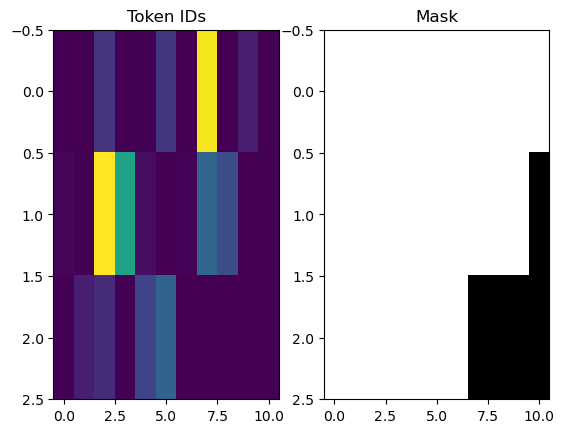

In [18]:
import torch

# Convert list of tensors to a padded tensor
from torch.nn.utils.rnn import pad_sequence

example_tokens_padded = pad_sequence(example_tokens, batch_first=True, padding_value=0)

plt.subplot(1, 2, 1)
plt.imshow(example_tokens_padded.numpy(), aspect='auto', cmap='viridis')
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.imshow(example_tokens_padded != 0, aspect='auto', cmap='gray')
plt.title('Mask')

plt.show()

In [19]:
# Create an upper triangular matrix
matrix_size = 8
matrix = np.zeros((matrix_size, matrix_size), dtype=int)
for i in range(matrix_size):
    for j in range(i, matrix_size):
        matrix[i, j] = 1

print(matrix)

[[1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]]


### Process the dataset



In [20]:
# Cell 20
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

def process_text(context, target, context_vocab, target_vocab, tokenizer, preprocess_func):
    # Preprocess and tokenize context
    context_processed = preprocess_func(context)
    context_tokens = context_vocab(tokenizer(context_processed))
    context_tensor = torch.tensor(context_tokens, dtype=torch.long)
    
    # Preprocess and tokenize target
    target_processed = preprocess_func(target)
    target_tokens = target_vocab(tokenizer(target_processed))
    target_tensor = torch.tensor(target_tokens, dtype=torch.long)
    
    # Create input and output for target (shifted by one)
    targ_in = target_tensor[:-1]
    targ_out = target_tensor[1:]
    
    return context_tensor, targ_in, targ_out

class TranslationDataset(Dataset):
    def __init__(self, contexts, targets, context_vocab, target_vocab, tokenizer, preprocess_func):
        self.contexts = contexts
        self.targets = targets
        self.context_vocab = context_vocab
        self.target_vocab = target_vocab
        self.tokenizer = tokenizer
        self.preprocess = preprocess_func
    
    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        context = self.contexts[idx]
        target = self.targets[idx]
        return process_text(context, target, self.context_vocab, self.target_vocab, self.tokenizer, self.preprocess)

# Define a collate function to pad sequences
def collate_fn(batch):
    contexts, targ_ins, targ_outs = zip(*batch)
    contexts_padded = pad_sequence(contexts, batch_first=True, padding_value=0)
    targ_ins_padded = pad_sequence(targ_ins, batch_first=True, padding_value=0)
    targ_outs_padded = pad_sequence(targ_outs, batch_first=True, padding_value=0)
    return contexts_padded, targ_ins_padded, targ_outs_padded

# Cell 8 (Updated)
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# Split the data into training and validation sets (80-20 split)
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_context = [context_raw[i] for i in range(len(context_raw)) if is_train[i]]
train_target = [target_raw[i] for i in range(len(target_raw)) if is_train[i]]

val_context = [context_raw[i] for i in range(len(context_raw)) if not is_train[i]]
val_target = [target_raw[i] for i in range(len(target_raw)) if not is_train[i]]

# Initialize the Dataset instances
train_dataset = TranslationDataset(
    train_context, train_target,
    context_vocab, target_vocab,
    tokenizer, torch_lower_and_split_punct
)

val_dataset = TranslationDataset(
    val_context, val_target,
    context_vocab, target_vocab,
    tokenizer, torch_lower_and_split_punct
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Here is the first sequence of each, from the first batch:

In [21]:
# Display processed tensors from the training set
for ex_context_tok, ex_tar_in, ex_tar_out in train_loader:
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_tar_in[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())
    break


[   0   13   11 1927    5    0   29    3    0    0]

[   0   24   12    6  454   18   32 1096    3    0]
[  24   12    6  454   18   32 1096    3    0    0]


## The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word.

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [22]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [23]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x):
        """
        Forward pass through the encoder.
        
        Args:
            x (Tensor): Input tokens, shape [batch, s]
        
        Returns:
            Tensor: Encoder outputs, shape [batch, s, hidden_size]
        """
        embedded = self.embedding(x)  # [batch, s, embedding_dim]
        outputs, hidden = self.gru(embedded)  # outputs: [batch, s, 2*hidden_size]
        # Sum bidirectional outputs
        outputs = outputs[:, :, :self.gru.hidden_size] + outputs[:, :, self.gru.hidden_size:]
        return outputs  # [batch, s, hidden_size]
    
    def convert_input(self, texts):
        """
        Converts a list of texts to tensor inputs for the encoder.

        Args:
            texts (List[str]): List of input sentences

        Returns:
            Tensor: Padded token indices, shape [batch, s]
        """
        processed_texts = [torch_lower_and_split_punct(text) for text in texts]
        tokenized = [tokenizer(text) for text in processed_texts]
        encoded = [context_vocab(tokens) for tokens in tokenized]
        # Convert each list of token indices to a tensor
        encoded_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in encoded]
        # Pad the sequences to create a uniform tensor
        padded = pad_sequence(encoded_tensors, batch_first=True, padding_value=0)
        return padded  # [batch, s]


Try it out:

In [24]:
# Initialize Encoder
encoder = Encoder(vocab_size=len(context_vocab), embedding_dim=UNITS, hidden_size=UNITS)

# Example context from the previous batch
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): torch.Size([64, 17])
Encoder output, shape (batch, s, units): torch.Size([64, 17, 256])


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [25]:
# CrossAttention Class
class CrossAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=1):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.add = nn.Identity() 

    def forward(self, x, context):
        """
        Forward pass through the CrossAttention layer.

        Args:
            x (Tensor): Query tensor, shape [batch, t, hidden_size]
            context (Tensor): Key and Value tensors, shape [batch, s, hidden_size]

        Returns:
            Tensor: Output tensor after attention, shape [batch, t, hidden_size]
        """
        # x: [batch, t, hidden_size]
        # context: [batch, s, hidden_size]
        attn_output, attn_weights = self.multihead_attn(query=x, key=context, value=context, need_weights=True)
        # attn_output: [batch, t, hidden_size]
        # attn_weights: [batch, t, s]

        # Cache the attention weights for plotting later
        self.last_attention_weights = attn_weights.mean(dim=1)  # Averaging over heads if multiple

        # Add & Normalize
        x = self.add(x + attn_output)
        x = self.layer_norm(x)
        return x


In [26]:
# Initialize Attention Layer
attention_layer = CrossAttention(hidden_size=UNITS)

# Initialize target embedding
class TargetEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(TargetEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    
    def forward(self, x):
        return self.embedding(x)

target_embedding = TargetEmbedding(vocab_size=len(target_vocab), embedding_dim=UNITS)

# Example target input from the previous batch
ex_tar_embed = target_embedding(ex_tar_in)

# Apply attention
result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s): {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): torch.Size([64, 17, 256])
Target sequence, shape (batch, t, units): torch.Size([64, 17, 256])
Attention result, shape (batch, t, units): torch.Size([64, 17, 256])
Attention weights, shape (batch, t, s): torch.Size([64, 17])


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [27]:
# Sum of attention weights should be close to 1 for each token
print(attention_layer.last_attention_weights[0].sum(dim=-1))

tensor(1.0000, grad_fn=<SumBackward1>)




Here are the attention weights across the context sequences at `t=0`:

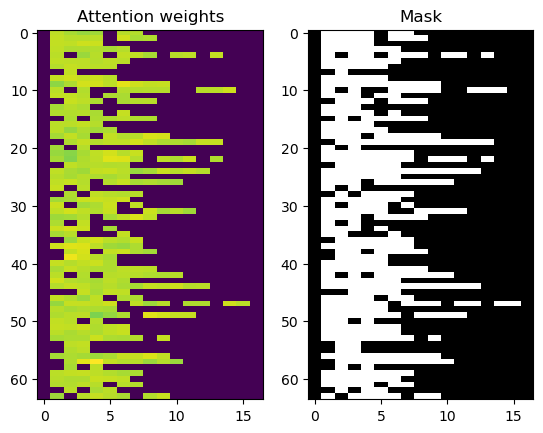

In [28]:
attention_weights = attention_layer.last_attention_weights.detach().numpy()
mask = (ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.imshow(mask * attention_weights, aspect='auto', cmap='viridis')
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.imshow(mask, aspect='auto', cmap='gray')
plt.title('Mask')

plt.show()

Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [29]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, target_vocab):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.attention = CrossAttention(hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
        # Utilize the existing target_vocab for word_to_id and id_to_word
        self.target_vocab = target_vocab
        self.id_to_word = target_vocab.get_itos()
    
    def forward(self, context, x, state=None):
        """
        Forward pass through the decoder.

        Args:
            context (Tensor): Encoder outputs, shape [batch, s, units] or [s, units]
            x (Tensor): Target input tokens, shape [batch, t]
            state (Tensor, optional): Initial hidden state for GRU

        Returns:
            logits (Tensor): Logits for each token, shape [batch, t, vocab_size]
            state (Tensor): Updated hidden state
        """
        # Ensure context has 3 dimensions: [batch, s, units]
        if context.dim() == 2:
            context = context.unsqueeze(0).float()  # Add batch dimension

        embedded = self.embedding(x)  # [batch, t, embedding_dim]
        output, state = self.gru(embedded, state)  # [batch, t, hidden_size]
        output = self.attention(output, context)  # [batch, t, hidden_size]
        logits = self.output_layer(output)  # [batch, t, vocab_size]
        return logits, state

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state.

That will be sufficient for training. Create an instance of the decoder to test out:

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token.

In [30]:
# Initialize Decoder with corrected class
decoder = Decoder(
    vocab_size=len(target_vocab),
    embedding_dim=UNITS,
    hidden_size=UNITS,
    target_vocab=target_vocab
)

# Example usage
logits, _ = decoder(ex_context, ex_tar_in)

print(f'Encoder output shape: {ex_context.shape}')
print(f'Input target tokens shape: {ex_tar_in.shape}')
print(f'Logits shape: {logits.shape}')

Encoder output shape: torch.Size([64, 17, 256])
Input target tokens shape: torch.Size([64, 17])
Logits shape: torch.Size([64, 17, 5000])


#### Inference

To use it for inference you'll need a couple more methods:

In [31]:
def get_initial_state(self, context):
    """
    Initializes the decoder's hidden state.
    
    Args:
        context (Tensor): Encoder outputs, shape [batch, s, units]
    
    Returns:
        start_tokens (Tensor): Tensor of [START] tokens, shape [batch, 1]
        done (Tensor): Tensor indicating completion, shape [batch, 1]
        state (Tensor): Initial hidden state, shape [1, batch, hidden_size]
    """
    batch_size = context.size(0)
    start_token_id = self.target_vocab['[START]']
    start_tokens = torch.full((batch_size, 1), start_token_id, dtype=torch.long, device=context.device)
    done = torch.zeros(batch_size, 1, dtype=torch.bool, device=context.device)
    # Initialize hidden state to zeros
    state = torch.zeros(1, batch_size, self.gru.hidden_size, device=context.device)
    return start_tokens, done, state

Decoder.get_initial_state = get_initial_state

In [32]:
def tokens_to_text(self, tokens):
    """
    Converts token IDs to human-readable text.
    
    Args:
        tokens (Tensor): Token IDs, shape [batch, t]
    
    Returns:
        List[str]: List of decoded strings for each batch item
    """
    # tokens: [batch, t]
    texts = []
    for token_seq in tokens.tolist():
        words = []
        for token in token_seq:
            word = self.id_to_word[token]
            if word == '[START]':
                continue
            elif word == '[END]':
                break
            else:
                words.append(word)
        text = ' '.join(words)
        texts.append(text)
    return texts

Decoder.tokens_to_text = tokens_to_text

In [33]:
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    """
    Generates the next token in the sequence.
    
    Args:
        context (Tensor): Encoder outputs, shape [batch, s, units]
        next_token (Tensor): Current token IDs, shape [batch, 1]
        done (Tensor): Completion flags, shape [batch, 1]
        state (Tensor): Current hidden state, shape [1, batch, hidden_size]
        temperature (float, optional): Sampling temperature
    
    Returns:
        next_token (Tensor): Next token IDs, shape [batch, 1]
        done (Tensor): Updated completion flags, shape [batch, 1]
        state (Tensor): Updated hidden state
    """
    logits, state = self.forward(context, next_token, state)  # logits: [batch, 1, vocab_size]
    logits = logits[:, -1, :]  # [batch, vocab_size]
    
    if temperature == 0.0:
        # Greedy decoding
        next_token = torch.argmax(logits, dim=-1, keepdim=True)  # [batch, 1]
    else:
        # Sampling with temperature
        logits = logits / temperature
        probabilities = torch.softmax(logits, dim=-1)  # [batch, vocab_size]
        next_token = torch.multinomial(probabilities, num_samples=1)  # [batch, 1]
    
    # Update done flags where [END] token is generated
    end_token_id = self.target_vocab['[END]']
    done = done | (next_token == end_token_id)  # [batch, 1]
    
    # Replace tokens where done is True with 0 (padding)
    next_token = torch.where(done, torch.zeros_like(next_token), next_token)  # [batch, 1]
    
    return next_token, done, state

Decoder.get_next_token = get_next_token

With those extra functions, you can write a generation loop:

In [34]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for _ in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)
    
# Concatenate all tokens
tokens = torch.cat(tokens, dim=1)  # [batch, t]

# Convert tokens to text
result = decoder.tokens_to_text(tokens)
print(result[:3])

['childish option socks finds eighty stir politics protect hobbies wet', 'suit seated happier giving policeman limits disturbing oxygen message rejected', 'needed split pet seems balloon ll side memorize darwin title']


Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [35]:
class Translator(nn.Module):
    def __init__(self, encoder, decoder):
        super(Translator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, context, x):
        context_encoded = self.encoder(context)
        logits, _ = self.decoder(context_encoded, x)
        return logits
    
    def translate(self, texts, max_length=50, temperature=0.0):
        # Encode the input texts
        context = self.encoder.convert_input(texts)  # [batch, s]
        context = context.to(next(self.encoder.parameters()).device)
        
        # Initialize loop variables
        next_token, done, state = self.decoder.get_initial_state(context)
        tokens = []
        
        for _ in range(max_length):
            next_token, done, state = self.decoder.get_next_token(
                context, next_token, done, state, temperature)
            tokens.append(next_token)
            if done.all():
                break
        
        # Concatenate tokens
        tokens = torch.cat(tokens, dim=1)  # [batch, t]
        
        # Convert tokens to text
        result = self.decoder.tokens_to_text(tokens)
        return result

During training the model will be used like this:

In [36]:
# Initialize Translator
model = Translator(encoder, decoder)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example forward pass
ex_context_tok = ex_context_tok.to(device)
ex_tar_in = ex_tar_in.to(device)
logits = model(ex_context_tok, ex_tar_in)

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) torch.Size([64, 17])
Target tokens, shape: (batch, t) torch.Size([64, 17])
logits, shape: (batch, t, target_vocabulary_size) torch.Size([64, 17, 5000])


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [37]:
def masked_loss(y_true, y_pred):
    # y_true: [batch, t]
    # y_pred: [batch, t, vocab_size]
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    loss = loss_fn(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1))
    
    # Reshape loss to [batch, t]
    loss = loss.view(y_true.size(0), y_true.size(1))
    
    # Mask out padding
    mask = (y_true != 0).float()
    loss *= mask
    
    # Return average loss per token
    return loss.sum() / mask.sum()

In [38]:
def masked_accuracy(y_true, y_pred):
    # y_pred: [batch, t, vocab_size]
    preds = torch.argmax(y_pred, dim=-1)  # [batch, t]
    matches = (preds == y_true).float()
    
    mask = (y_true != 0).float()
    matches *= mask
    
    return matches.sum() / mask.sum()

Configure the model for training:

In [39]:
optimizer = optim.Adam(model.parameters())

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [40]:
vocab_size = len(target_vocab)

expected_loss = np.log(vocab_size)
expected_acc = 1 / vocab_size

print({"expected_loss": np.log(vocab_size), "expected_acc": expected_acc})

{'expected_loss': 8.517193191416238, 'expected_acc': 0.0002}


That should roughly match the values returned by running a few steps of evaluation:

In [41]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_tokens = 0
    with torch.no_grad():
        for context, target_in, target_out in dataloader:
            context = context.to(device)
            target_in = target_in.to(device)
            target_out = target_out.to(device)
            
            logits = model(context, target_in)
            loss = masked_loss(target_out, logits)
            acc = masked_accuracy(target_out, logits)
            
            total_loss += loss.item()
            total_acc += acc.item()
    return {"loss": total_loss / len(dataloader), "accuracy": total_acc / len(dataloader)}

# Evaluate on validation set (first 20 steps)
val_results = evaluate(model, val_loader, device)
print(val_results)

{'loss': 8.694419691639562, 'accuracy': 0.00010627256337082594}


In [42]:
from tqdm import tqdm

EPOCHS = 100
PATIENCE = 3
best_val_loss = float('inf')
patience_counter = 0

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for context, target_in, target_out in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        context = context.to(device)
        target_in = target_in.to(device)
        target_out = target_out.to(device)
        
        optimizer.zero_grad()
        logits = model(context, target_in)
        loss = masked_loss(target_out, logits)
        acc = masked_accuracy(target_out, logits)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)
    
    # Evaluate on validation set
    val_results = evaluate(model, val_loader, device)
    
    history['loss'].append(avg_loss)
    history['accuracy'].append(avg_acc)
    history['val_loss'].append(val_results['loss'])
    history['val_accuracy'].append(val_results['accuracy'])
    
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={avg_acc:.4f}, Val Loss={val_results['loss']:.4f}, Val Acc={val_results['accuracy']:.4f}")
    
    # Early Stopping
    if val_results['loss'] < best_val_loss:
        best_val_loss = val_results['loss']
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1: 100%|██████████| 1487/1487 [00:14<00:00, 99.57it/s] 


Epoch 1: Loss=2.6583, Acc=0.5451, Val Loss=1.7465, Val Acc=0.6657


Epoch 2: 100%|██████████| 1487/1487 [00:14<00:00, 100.51it/s]


Epoch 2: Loss=1.4899, Acc=0.6947, Val Loss=1.5114, Val Acc=0.7013


Epoch 3: 100%|██████████| 1487/1487 [00:14<00:00, 101.36it/s]


Epoch 3: Loss=1.1672, Acc=0.7413, Val Loss=1.4588, Val Acc=0.7132


Epoch 4: 100%|██████████| 1487/1487 [00:14<00:00, 101.17it/s]


Epoch 4: Loss=0.9721, Acc=0.7724, Val Loss=1.4542, Val Acc=0.7184


Epoch 5: 100%|██████████| 1487/1487 [00:14<00:00, 100.96it/s]


Epoch 5: Loss=0.8272, Acc=0.7979, Val Loss=1.4806, Val Acc=0.7202


Epoch 6: 100%|██████████| 1487/1487 [00:14<00:00, 100.97it/s]


Epoch 6: Loss=0.7183, Acc=0.8186, Val Loss=1.5154, Val Acc=0.7212


Epoch 7: 100%|██████████| 1487/1487 [00:14<00:00, 101.41it/s]


Epoch 7: Loss=0.6331, Acc=0.8359, Val Loss=1.5462, Val Acc=0.7209
Early stopping triggered.


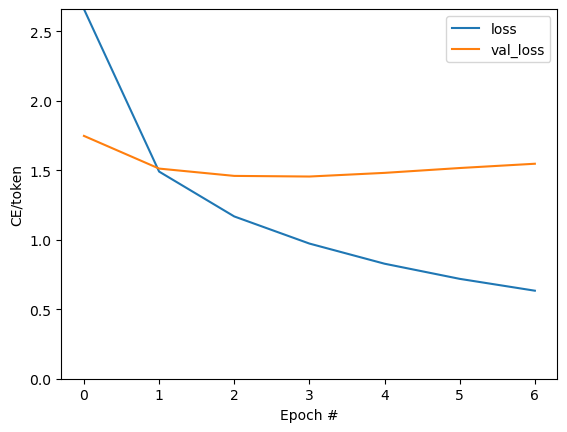

In [43]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylim([0, max(max(history['loss']), max(history['val_loss']))])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()

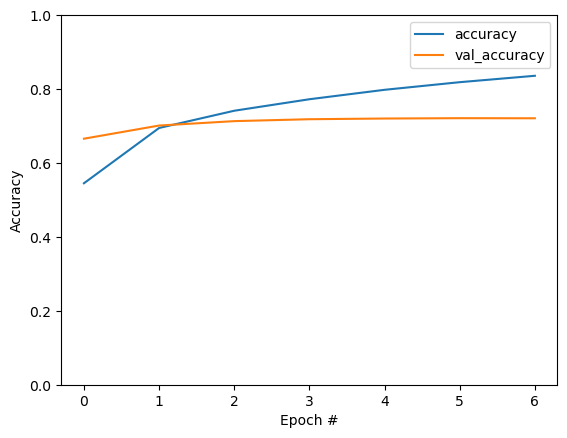

In [44]:
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()